# Goal

This notebook imports the pyPI code and test data, computes the PI module (pi.py) output, and then performs a few standard analyses on PI data.

In [1]:
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import time
# load PI calculation module
from pi import pi

In [2]:
# change default figure font settings
font = {'family' : 'sans-serif',
        'weight' : 1,
        'size'   : 16}

matplotlib.rc('font', **font)

# Load Data

In [3]:
# data location
_FN='./data/test_data.nc'
# load netcdf file
ds = xr.open_dataset(_FN)
# define the CKCD ratio
CKCD=0.9

# Calculate PI and Variables

PI is given by the Bister and Emanuel (2002) algorithm (see pi.py):

In [4]:
# create a function to calculate PI over the sample dataset using xarray
def run_sample_dataset(fn, dim='p'):
    
    # open the test data file
    ds = xr.open_dataset(_FN)
    # calculate PI over the whole data set using the xarray universal function
    result = xr.apply_ufunc(
        pi,
        ds['sst'], ds['msl'], ds['p'], ds['t'], ds['q'],
        kwargs=dict(CKCD=CKCD, ascent_flag=0, diss_flag=1, miss_handle=1),
        input_core_dims=[
            [], [], ['p', ], ['p', ], ['p', ],
        ],
        output_core_dims=[
            [], [], [], [], []
        ],
        vectorize=True
    )

    vmax, pmin, ifl, t0, lnb = result

    # return the output from pi.py as an xarray data structure
    return xr.Dataset({
        'vmax': vmax, 
        'pmin': pmin,
        'ifl': ifl,
        't0': t0,
        'lnb': lnb
    })

In [5]:
# calculate PI over the sample test data
pi_ds=run_sample_dataset(_FN)

## Main development regions (MDRs)

We define the TC main development regions following Gilford et al. (2017):

<img src="figures/mdrs.png" alt="Drawing" style="width: 400px;"/>

In [6]:
bounds = xr.Dataset({
            'na': (
                ("lat", "lon"),
                np.asarray([8.75, 31.25, 266.25-180, 308.75-180]).reshape(2,2),
                ),
            'enp': (
                ("lat", "lon"),
                np.asarray([3.75, 16.25, 191.25-180, 268.75-180]).reshape(2,2),
                ),
            'wnp': (
                ("lat", "lon"),
                np.asarray([3.75, 16.25, 131.25-180, 178.75-180]).reshape(2,2),
                ),
            'ni': (
                ("lat", "lon"),
                np.asarray([3.75, 21.25, 51.25-180, 108.75-180]).reshape(2,2),
                ),
            'sh': (
                ("lat", "lon"),
                np.asarray([-18.75, 3.75, 61.25-180, 178.75-180]).reshape(2,2),
                ),
        })

## Compute diagnostics

PI may also be computed directly via:

EQN.

Where...

### Efficiency, Disequilibrium, and Decomposition

The efficiency...
Typical...


We decompose each term in this equation by...

CKCD default

SAME UNITS!

In [7]:
def pi_effiency(sstk,t0):
    # calculate efficiency with SST (K) and Outflow temperature (K)
    efficiency=(sstk-t0)/t0
    return(efficiency)

def pi_diseq_resid(pi,sstk,t0,CKCD=0.9):
    import numpy as np
    efficiency=(sstk-t0)/t0
    diseq=pi**2/(CKCD*efficiency)
    return(diseq)

def decompose_pi(pi,sstk,t0,CKCD=0.9):
    import numpy as np
    lnCKCD=np.log(CKCD)
    efficiency=(sstk-t0)/t0
    if (efficiency>0):
        diseq=pi**2/(CKCD*efficiency)
        lneff=np.log(efficiency)
        if pi>0:
            lnpi=2*np.log(pi)
            lndiseq=lnpi-lneff-lnCKCD
            return(lnpi,lneff,lndiseq,lnCKCD)
        else:
            return(np.nan,lneff,np.nan,lnCKCD)
    else:
        return(np.nan,np.nan,np.nan,lnCKCD)
    
def run_diagnostics(pi_ds,sst,CKCD=0.9):
    
    # calculate PI diagnostics over the whole data set using the xarray universal function
    efficiency = xr.apply_ufunc(
        pi_effiency,
        sst, pi_ds['t0'],
        input_core_dims=[
            [], [],
        ],
        output_core_dims=[
            [],
        ],
        vectorize=True
    )
    
    diseq = xr.apply_ufunc(
        pi_diseq_resid,
        pi_ds['vmax'], sst, pi_ds['t0'],
        kwargs=dict(CKCD=0.9),
        input_core_dims=[
            [], [], [],
        ],
        output_core_dims=[
            [],
        ],
        vectorize=True
    )
    
    result1 = xr.apply_ufunc(
        decompose_pi,
        pi_ds['vmax'], sst, pi_ds['t0'],
        kwargs=dict(CKCD=0.9),
        input_core_dims=[
            [], [], [],
        ],
        output_core_dims=[
            [], [], [], [],
        ],
        vectorize=True
    )

    lnpi, lneff, lndiseq, lnCKCD = result1


    # return the output from pi.py as an xarray data structure
    return xr.Dataset({
        'eff': efficiency, 
        'diseq': diseq,
        'lnpi': lnpi,
        'lneff': lneff,
        'lndiseq': lndiseq,
        'lnCKCD': lnCKCD[0,0,0]
    })

In [35]:
diag_ds=run_diagnostics(pi_ds,ds.sst+273.15,CKCD=CKCD)

# Perform and Plot Analyses

## Annual Climatology

### PI ($V_{max}$)

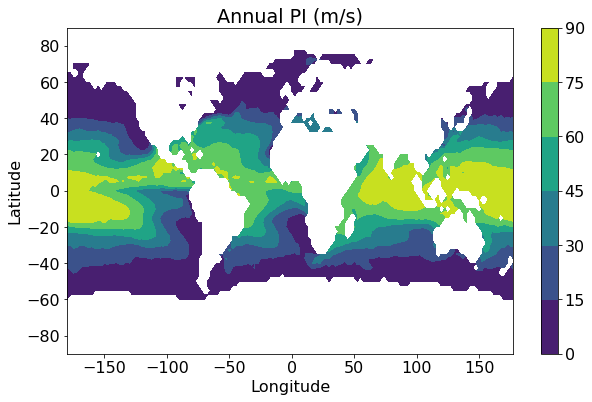

In [28]:
plt.figure(figsize=(10,6))
plt.contourf(pi_ds.lon,pi_ds.lat,pi_ds.vmax.mean(dim=['month']))
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('Annual PI (m/s)')
plt.colorbar()
plt.show()

### Sea Surface Temperature ($T_{s}$)

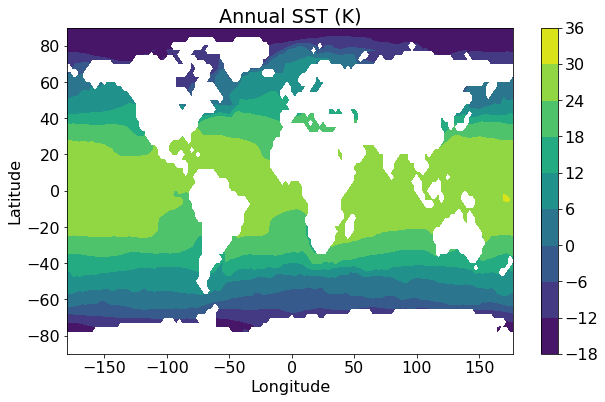

In [29]:
plt.figure(figsize=(10,6))
plt.contourf(pi_ds.lon,pi_ds.lat,ds.sst.mean(dim=['month']))
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('Annual SST (K)')
plt.colorbar()
plt.show()

### Outflow Temperature ($T_0$)

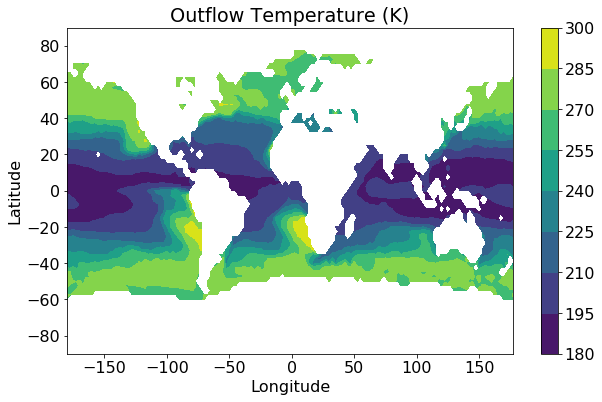

In [30]:
plt.figure(figsize=(10,6))
plt.contourf(pi_ds.lon,pi_ds.lat,pi_ds.t0.mean(dim=['month']))
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('Outflow Temperature (K)')
plt.colorbar()
plt.show()

### Outflow Temperature Level (OTL)

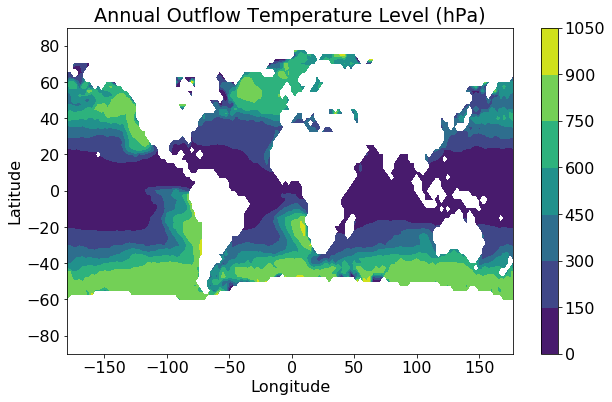

In [31]:
plt.figure(figsize=(10,6))
plt.contourf(pi_ds.lon,pi_ds.lat,pi_ds.lnb.mean(dim=['month']))
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('Annual Outflow Temperature Level (hPa)')
plt.colorbar()
plt.show()

### TC Efficiency ($\frac{T_{s} - T_{0}}{T_{0}}$)

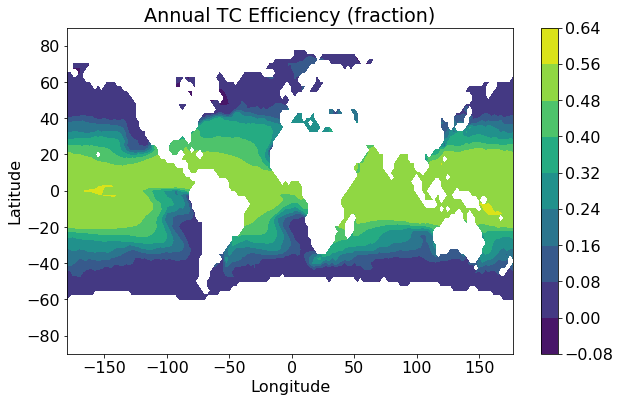

In [39]:
plt.figure(figsize=(10,6))
plt.contourf(pi_ds.lon,pi_ds.lat,diag_ds.eff.mean(dim=['month']))
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('Annual TC Efficiency (fraction)')
plt.colorbar()
plt.show()

### ln[Disequlibrium] ($h^* - h$)

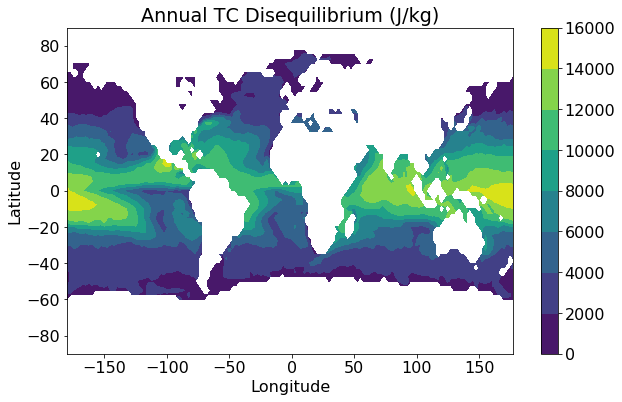

In [38]:
plt.figure(figsize=(10,6))
plt.contourf(pi_ds.lon,pi_ds.lat,diag_ds.diseq.mean(dim=['month']))
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('Annual TC Disequilibrium (J/kg)')
plt.colorbar()
plt.show()

## Seasonal Climatology by Basin

In [40]:
MAKE FUNCTION TO TAKE WEIGHTED AVERAGE, CALCULATE SEASONAL CYCLES

SyntaxError: invalid syntax (<ipython-input-40-c46c0bc08fe9>, line 1)